In [1]:
# Import libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import math
%matplotlib inline

In [2]:
import os

In [3]:
# Environment variables
os.environ["http_proxy"]='http://wwwproxy.frb.gov:8080'
os.environ["https_proxy"]='http://wwwproxy.frb.gov:8080'
os.environ["HTTP_PROXY"]='http://wwwproxy.frb.gov:8080'
os.environ["HTTPS_PROXY"]='http://wwwproxy.frb.gov:8080'
os.environ["NO_PROXY"]='localhost,127.0.0.1,*.frb.gov,.frb.gov,.frb.org,*.frb.org,.frb.pvt,*.frb.pvt'
os.environ['CURL_CA_BUNDLE'] = ''

In [4]:
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")

C:\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'wwwproxy.frb.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [5]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")

C:\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'wwwproxy.frb.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [6]:
# Function to perform sentiment analysis on text data
def predict_sentiment(text_data):
    # Tokenize the input text data
    tokens = tokenizer(text_data, padding=True, truncation=True, return_tensors='pt')
    
    # Pass the tokenized data through the finBERT model to get predicted sentiment scores
    with torch.no_grad():
        outputs = model(**tokens)
        logits = outputs.logits

    # Get predicted sentiment labels (positive, neutral, negative) from logits
    _, predicted_labels = torch.max(logits, dim=1)
    # Convert the logits to probabilities
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    # Convert probabilities tensor to numpy array
    probs_np = probs.detach().numpy()

    # Map numerical labels back to sentiment categories
    sentiment_mapping = {0: "negative", 1: "neutral", 2: "positive"}
    predicted_sentiments = [sentiment_mapping[label.item()] for label in predicted_labels]
    predicted_sentiments_pd=pd.DataFrame({"Text": text_data, "Predicted Sentiment": predicted_sentiments})
    # Create a new DataFrame with dates and probabilities
    df_probs = pd.DataFrame({
    'negative_prob': probs_np[:, 0],
    'neutral_prob': probs_np[:, 1],
    'positive_prob': probs_np[:, 2]
    })
    #print(probs_np)
    #print(df_results)
    predicted_sentiments_pr = pd.concat([predicted_sentiments_pd, df_probs], axis=1) 
    
   # print(predicted_sentiments_pr)
    return predicted_sentiments_pr

In [7]:
# The function that splits each statment text into seperate sentences. 
def sentence_split(text):
    return re.split(r'(?<=\w\.)\s+',text)


In [8]:
#   Load the text data 
text_dta = pd.read_excel('fomc_statements.xlsx', sheet_name='statements')

In [9]:
# Call the function to split the sentences for each date
text_dta["Statement_sentence"] = text_dta["Statement"].apply(sentence_split)

In [10]:
text_dta

,Date,Statement,Statement_sentence
0,2000-02-02,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...
1,2000-03-21,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...
2,2000-05-16,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...
3,2000-06-28,The Federal Open Market Committee at its meeti...,[The Federal Open Market Committee at its meet...
4,2000-08-22,The Federal Open Market Committee at its meeti...,[The Federal Open Market Committee at its meet...
...,...,...,...
197,2023-02-01,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...
198,2023-03-22,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...
199,2023-05-03,Economic activity expanded at a modest pace in...,[Economic activity expanded at a modest pace i...
200,2023-06-14,Recent indicators suggest that economic activi...,[Recent indicators suggest that economic activ...


In [11]:
# Check the splitted text 
text_dta["Statement_sentence"][1]

['The Federal Open Market Committee voted today to raise its target for the federal funds rate by 25 basis points to 6 percent.',
 'In a related action, the Board of Governors approved a 25 basis point increase in the discount rate to 5-1/2 percent.',
 'Economic conditions and considerations addressed by the Committee are essentially the same as when the Committee met in February.',
 "The Committee remains concerned that increases in demand will continue to exceed the growth in potential supply, which could foster inflationary imbalances that would undermine the economy's record economic expansion.",
 'Against the background of its long-run goals of price stability and sustainable economic growth and of the information currently available, the Committee believes the risks are weighted mainly toward conditions that may generate heightened inflation pressures in the foreseeable future.',
 'In taking the discount rate action, the Federal Reserve Board approved requests submitted by the Bo

In [12]:
text_dta["Statement_sentence"][201]



['Recent indicators suggest that economic activity has been expanding at a moderate pace.',
 'Job gains have been robust in recent months, and the unemployment rate has remained low.',
 'Inflation remains elevated.',
 'The US banking system is sound and resilient.',
 'Tighter credit conditions for households and businesses are likely to weigh on economic activity, hiring, and inflation.',
 'The extent of these effects remains uncertain.',
 'The Committee remains highly attentive to inflation risks.',
 'The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run.',
 'In support of these goals, the Committee decided to raise the target range for the federal funds rate to 5-1/4 to 5-1/2 percent.',
 'The Committee will continue to assess additional information and its implications for monetary policy.',
 'In determining the extent of additional policy firming that may be appropriate to return inflation to 2 percent over time, the Committee w

In [13]:
# Here we use the Statements as a series object so that iteratioon below can be executed
text_data = text_dta["Statement_sentence"]

In [14]:
text_data

0      [The Federal Open Market Committee voted today...
1      [The Federal Open Market Committee voted today...
2      [The Federal Open Market Committee voted today...
3      [The Federal Open Market Committee at its meet...
4      [The Federal Open Market Committee at its meet...
                             ...                        
197    [Recent indicators point to modest growth in s...
198    [Recent indicators point to modest growth in s...
199    [Economic activity expanded at a modest pace i...
200    [Recent indicators suggest that economic activ...
201    [Recent indicators suggest that economic activ...
Name: Statement_sentence, Length: 202, dtype: object

In [15]:
# Starting here, the code iterates over each statement and collects FOMC Sentiment Index in a list

In [16]:
if __name__ == "__main__":
    fomc_si = []
    for value in text_data:
        text_i = value 
        #print(text_i)
        predicted_sentiments = predict_sentiment(text_i)
        predicted_sentiments['fomc_indx_num'] = np.where(predicted_sentiments['Predicted Sentiment']== 'neutral', 0, -1*predicted_sentiments['negative_prob'] + 1*predicted_sentiments['positive_prob'])
        fomc_si.append( -predicted_sentiments['fomc_indx_num'].mean())
    
        #print(fomc_si)


In [17]:
# Once the list of index values are obtained then we first put them in a dataframe and then combine back with the original 
# text data so that further analysis can be conducted.

In [18]:
fomc_si_df = pd.DataFrame(fomc_si, columns=['FOMC Sentiment Index'])
fomc_si_df = pd.concat([text_dta, fomc_si_df], axis =1) 

In [19]:
fomc_si_df

,Date,Statement,Statement_sentence,FOMC Sentiment Index
0,2000-02-02,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...,-0.070471
1,2000-03-21,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...,-0.328228
2,2000-05-16,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...,-0.189807
3,2000-06-28,The Federal Open Market Committee at its meeti...,[The Federal Open Market Committee at its meet...,0.261819
4,2000-08-22,The Federal Open Market Committee at its meeti...,[The Federal Open Market Committee at its meet...,0.157841
...,...,...,...,...
197,2023-02-01,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...,-0.204598
198,2023-03-22,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...,-0.215664
199,2023-05-03,Economic activity expanded at a modest pace in...,[Economic activity expanded at a modest pace i...,-0.331973
200,2023-06-14,Recent indicators suggest that economic activi...,[Recent indicators suggest that economic activ...,-0.338477


In [20]:
print(fomc_si_df['Date'])

0     2000-02-02
1     2000-03-21
2     2000-05-16
3     2000-06-28
4     2000-08-22
         ...    
197   2023-02-01
198   2023-03-22
199   2023-05-03
200   2023-06-14
201   2023-07-26
Name: Date, Length: 202, dtype: datetime64[ns]


In [21]:
fomc_si_df['Date'] = pd.to_datetime(fomc_si_df['Date'], errors='coerce')
#fomc_si_df['Date'] = pd.to_datetime(fomc_si_df['Date'])
fomc_si_df.set_index('Date', inplace=True)

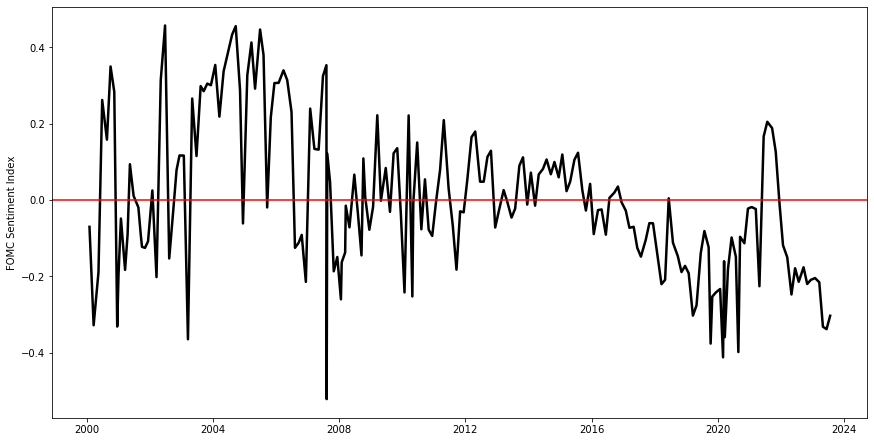

In [22]:
fig, ax1 = plt.subplots(figsize = (12, 6))
ax1.set_ylabel('FOMC Sentiment Index', color='black')
ax1.tick_params(axis ='y', labelcolor='black')

ax1.plot(fomc_si_df['FOMC Sentiment Index'], color='black', linewidth=2.5, linestyle='-')
ax1.axhline(y=0, color = 'red', linestyle = '-'  )
#ax2.plot(df['Int_Rate_Diff_DEPOSIT_1M_TR']/12, color='brown')
#ax2.plot(df['Int_Rate_Diff_DEPOSIT_1M']/12, color='purple')
#ax2.tick_params(axis = 'y', labelcolor='purple')

fig.tight_layout()
fig.tight_layout(pad=0.2)
fig.savefig("FOMC_Sentiment_Index.png")

In [23]:
fomc_si_des_stat = fomc_si_df['FOMC Sentiment Index'].describe()
print(fomc_si_des_stat)

count    202.000000
mean      -0.002321
std        0.195040
min       -0.521710
25%       -0.139679
50%       -0.020917
75%        0.116388
max        0.456938
Name: FOMC Sentiment Index, dtype: float64


In [24]:
# End of the main code that produces the FOMC Sentiment Index!!!

### Exploring correlation of the Sentiment Index with Economic Variables

In [25]:
fomc_dates = pd.read_excel('VIXCLS.xlsx')

In [26]:
statement_dates = fomc_dates[["Statement_Date"]]
statement_dates = statement_dates.dropna()

In [27]:
def index_date_set(data, date_column):
    data.index = pd.to_datetime(data.iloc[:,date_column]).dt.normalize()
    data.index.names = (['Date']) 
    data = data.drop(data.columns[date_column], axis=1)
    return(data)

In [28]:
statement_dates["placeholder"] = 1
statement_dates = index_date_set(statement_dates, 0)

In [29]:
statement_dates

,placeholder
Date,
2000-02-02,1
2000-03-21,1
2000-05-16,1
2000-06-28,1
2000-08-22,1
...,...
2023-02-01,1
2023-03-22,1
2023-05-03,1


In [30]:
Vol_data_file = pd.read_excel("VolatilityIndices.xlsx",sheet_name='BloombergDataUpdate', header=[3],usecols='A, C,L,E:J, M')
Vol_indices = Vol_data_file
Vol_indices = Vol_indices.drop(Vol_indices.index[:2])


Vol_indices.index = pd.to_datetime(Vol_indices.iloc[:,0]).dt.normalize()
Vol_indices.index.names = (['Date']) #  Renaming keys for row index
Vol_indices = Vol_indices.drop(Vol_indices.columns[0], axis=1)
Vol_indices = Vol_indices.astype(float)
Vol_indices = Vol_indices.drop(Vol_indices.columns[[3,4,6]], axis=1)
vix= Vol_indices[["VIX Index"]]
vix = vix.dropna()
vix

,VIX Index
Date,
2000-01-04,27.01
2000-01-05,26.41
2000-01-06,25.73
2000-01-07,21.72
2000-01-10,21.71
...,...
2023-07-26,13.19
2023-07-27,14.41
2023-07-28,13.33


In [31]:
merged_dta= vix.join(statement_dates)
merged_dta = merged_dta.fillna(0)
merged_dta

,VIX Index,placeholder
Date,,
2000-01-04,27.01,0.0
2000-01-05,26.41,0.0
2000-01-06,25.73,0.0
2000-01-07,21.72,0.0
2000-01-10,21.71,0.0
...,...,...
2023-07-26,13.19,1.0
2023-07-27,14.41,0.0
2023-07-28,13.33,0.0


In [32]:
merged_dta["group_num"]=0
merged_dta

,VIX Index,placeholder,group_num
Date,,,
2000-01-04,27.01,0.0,0
2000-01-05,26.41,0.0,0
2000-01-06,25.73,0.0,0
2000-01-07,21.72,0.0,0
2000-01-10,21.71,0.0,0
...,...,...,...
2023-07-26,13.19,1.0,0
2023-07-27,14.41,0.0,0
2023-07-28,13.33,0.0,0


In [33]:
j=1
for i in range(0,len(merged_dta.index)):
    if merged_dta.iloc[i,1]==0:
        merged_dta.iloc[i,2]=j
    else:
        j+=1
merged_dta

,VIX Index,placeholder,group_num
Date,,,
2000-01-04,27.01,0.0,1
2000-01-05,26.41,0.0,1
2000-01-06,25.73,0.0,1
2000-01-07,21.72,0.0,1
2000-01-10,21.71,0.0,1
...,...,...,...
2023-07-26,13.19,1.0,0
2023-07-27,14.41,0.0,201
2023-07-28,13.33,0.0,201


In [34]:
average_vix = pd.DataFrame({"vix_mean":merged_dta.groupby(['group_num'])['VIX Index'].mean()})
average_vix 

,vix_mean
group_num,
0,20.669100
1,22.997143
2,23.091818
3,26.720000
4,22.823667
...,...
197,21.127647
198,18.364138
199,16.669310


In [35]:
#average_vix = pd.DataFrame({"vix_mean":merged_dta.groupby(['group_num'])['VIX Index'].mean()})
#average_spx = pd.DataFrame({"spx_mean":merged_dta.groupby(['group_num'])['SPX RET'].mean()})
average_vix 

,vix_mean
group_num,
0,20.669100
1,22.997143
2,23.091818
3,26.720000
4,22.823667
...,...
197,21.127647
198,18.364138
199,16.669310


In [36]:
#Calculates daily percent changes per group
pct_vix = pd.DataFrame({"pct_vix":merged_dta.groupby(['group_num'])['VIX Index'].pct_change()})
#We have to re-merge the pct_vix data set with merged_dta to recover the gruop numbers
pct_vix = merged_dta.join(pct_vix)
pct_vix

,VIX Index,placeholder,group_num,pct_vix
Date,,,,
2000-01-04,27.01,0.0,1,NaN
2000-01-05,26.41,0.0,1,-0.022214
2000-01-06,25.73,0.0,1,-0.025748
2000-01-07,21.72,0.0,1,-0.155849
2000-01-10,21.71,0.0,1,-0.000460
...,...,...,...,...
2023-07-26,13.19,1.0,0,-0.049712
2023-07-27,14.41,0.0,201,NaN
2023-07-28,13.33,0.0,201,-0.074948


In [37]:
pct_vix = pd.DataFrame({"pct_vix_change":pct_vix.groupby(['group_num'])['pct_vix'].mean()})
pct_vix

,pct_vix_change
group_num,
0,0.025132
1,-0.004718
2,0.003302
3,0.006043
4,-0.002817
...,...
197,0.006450
198,-0.007552
199,-0.009736


In [38]:
vix_change = average_vix.join(pct_vix)
vix_change

,vix_mean,pct_vix_change
group_num,,
0,20.669100,0.025132
1,22.997143,-0.004718
2,23.091818,0.003302
3,26.720000,0.006043
4,22.823667,-0.002817
...,...,...
197,21.127647,0.006450
198,18.364138,-0.007552
199,16.669310,-0.009736


In [39]:
statement_dates = fomc_dates[["Statement_Date"]]
statement_dates = statement_dates.dropna()
#drops the first FOMC date since we are pegging each group to the second fomc date. 
statement_dates = statement_dates.drop(statement_dates.index[0])
#shifts index back by one
statement_dates.index =statement_dates.index -1
statement_dates.index.names = (['group_num'])
statement_dates

,Statement_Date
group_num,
0,2000-03-21
1,2000-05-16
2,2000-06-28
3,2000-08-22
4,2000-10-03
...,...
196,2023-02-01
197,2023-03-22
198,2023-05-03


In [40]:
vix_change = vix_change.join(statement_dates)
vix_change =index_date_set(vix_change, 2) 
vix_change

,vix_mean,pct_vix_change
Date,,
2000-03-21,20.669100,0.025132
2000-05-16,22.997143,-0.004718
2000-06-28,23.091818,0.003302
2000-08-22,26.720000,0.006043
2000-10-03,22.823667,-0.002817
...,...,...
2023-03-22,21.127647,0.006450
2023-05-03,18.364138,-0.007552
2023-06-14,16.669310,-0.009736


In [41]:
#Drop last group since the data does not end of an FOMC meeting
vix_change = vix_change.drop(vix_change.index[-1])
vix_change

,vix_mean,pct_vix_change
Date,,
2000-03-21,20.669100,0.025132
2000-05-16,22.997143,-0.004718
2000-06-28,23.091818,0.003302
2000-08-22,26.720000,0.006043
2000-10-03,22.823667,-0.002817
...,...,...
2023-02-01,20.742647,-0.003965
2023-03-22,21.127647,0.006450
2023-05-03,18.364138,-0.007552


In [42]:
# Now merge/concatinate the vix data with the sentiment index data
fomc_si_df = pd.concat([vix_change, fomc_si_df], axis =1) 

In [43]:
fomc_si_df['FOMC_SI']= fomc_si_df['FOMC Sentiment Index']

In [44]:
fomc_si_df

,vix_mean,pct_vix_change,Statement,Statement_sentence,FOMC Sentiment Index,FOMC_SI
Date,,,,,,
2000-02-02,NaN,NaN,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...,-0.070471,-0.070471
2000-03-21,20.669100,0.025132,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...,-0.328228,-0.328228
2000-05-16,22.997143,-0.004718,The Federal Open Market Committee voted today ...,[The Federal Open Market Committee voted today...,-0.189807,-0.189807
2000-06-28,23.091818,0.003302,The Federal Open Market Committee at its meeti...,[The Federal Open Market Committee at its meet...,0.261819,0.261819
2000-08-22,26.720000,0.006043,The Federal Open Market Committee at its meeti...,[The Federal Open Market Committee at its meet...,0.157841,0.157841
...,...,...,...,...,...,...
2023-02-01,20.742647,-0.003965,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...,-0.204598,-0.204598
2023-03-22,21.127647,0.006450,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...,-0.215664,-0.215664
2023-05-03,18.364138,-0.007552,Economic activity expanded at a modest pace in...,[Economic activity expanded at a modest pace i...,-0.331973,-0.331973


### Regression Analysis with FOMC SI

In [45]:
fomc_si_des_stat = fomc_si_df.describe()
print(fomc_si_des_stat)

         vix_mean  pct_vix_change  FOMC Sentiment Index     FOMC_SI
count  201.000000      201.000000            202.000000  202.000000
mean    20.728545        0.004726             -0.002321   -0.002321
std      8.758038        0.020357              0.195040    0.195040
min     10.045862       -0.021672             -0.521710   -0.521710
25%     14.360690       -0.003278             -0.139679   -0.139679
50%     19.011724        0.001530             -0.020917   -0.020917
75%     24.186786        0.007492              0.116388    0.116388
max     65.775714        0.234499              0.456938    0.456938


In [46]:
fomc_si_df.tail()

,vix_mean,pct_vix_change,Statement,Statement_sentence,FOMC Sentiment Index,FOMC_SI
Date,,,,,,
2023-02-01,20.742647,-0.003965,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...,-0.204598,-0.204598
2023-03-22,21.127647,0.006450,Recent indicators point to modest growth in sp...,[Recent indicators point to modest growth in s...,-0.215664,-0.215664
2023-05-03,18.364138,-0.007552,Economic activity expanded at a modest pace in...,[Economic activity expanded at a modest pace i...,-0.331973,-0.331973
2023-06-14,16.669310,-0.009736,Recent indicators suggest that economic activi...,[Recent indicators suggest that economic activ...,-0.338477,-0.338477
2023-07-26,13.870000,-0.000902,Recent indicators suggest that economic activi...,[Recent indicators suggest that economic activ...,-0.303406,-0.303406


In [47]:
### Sample correlation coefficients 
print(fomc_si_df[['vix_mean', 'pct_vix_change', 'FOMC_SI' ]].corr())

                vix_mean  pct_vix_change   FOMC_SI
vix_mean        1.000000        0.115565 -0.125921
pct_vix_change  0.115565        1.000000 -0.064701
FOMC_SI        -0.125921       -0.064701  1.000000


In [48]:
### Regressions

In [49]:
fomc_si_model = smf.ols('FOMC_SI ~ vix_mean', data = fomc_si_df).fit(cov_type='HAC', cov_kwds={'maxlags':0}, use_t=True)
print(fomc_si_model.summary())

                            OLS Regression Results                            
Dep. Variable:                FOMC_SI   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.277
Date:                Tue, 01 Aug 2023   Prob (F-statistic):             0.0718
Time:                        18:14:33   Log-Likelihood:                 45.006
No. Observations:                 201   AIC:                            -86.01
Df Residuals:                     199   BIC:                            -79.41
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0563      0.037      1.527      0.1

In [50]:
fomc_si_model = smf.ols('vix_mean ~ FOMC_SI.shift(1)', data = fomc_si_df).fit(cov_type='HAC', cov_kwds={'maxlags':0}, use_t=True)
print(fomc_si_model.summary())

                            OLS Regression Results                            
Dep. Variable:               vix_mean   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     11.81
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           0.000717
Time:                        18:14:39   Log-Likelihood:                -717.20
No. Observations:                 201   AIC:                             1438.
Df Residuals:                     199   BIC:                             1445.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           20.7215      0.605  

In [51]:
fomc_si_model = smf.ols('vix_mean ~ vix_mean.shift(1) + FOMC_SI.shift(1)', data = fomc_si_df).fit(cov_type='HAC', cov_kwds={'maxlags':0}, use_t=True)
print(fomc_si_model.summary())

                            OLS Regression Results                            
Dep. Variable:               vix_mean   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     110.4
Date:                Tue, 01 Aug 2023   Prob (F-statistic):           6.91e-33
Time:                        18:14:44   Log-Likelihood:                -612.91
No. Observations:                 200   AIC:                             1232.
Df Residuals:                     197   BIC:                             1242.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.2898      1.06

In [52]:
fomc_si_model = smf.ols('pct_vix_change ~ FOMC_SI', data = fomc_si_df).fit(cov_type='HAC', cov_kwds={'maxlags':0}, use_t=True)
print(fomc_si_model.summary())

                            OLS Regression Results                            
Dep. Variable:         pct_vix_change   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                     1.825
Date:                Tue, 01 Aug 2023   Prob (F-statistic):              0.178
Time:                        18:14:49   Log-Likelihood:                 498.47
No. Observations:                 201   AIC:                            -992.9
Df Residuals:                     199   BIC:                            -986.3
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0047      0.001      3.299      0.0

In [ ]:
#### End of the analysis for VIX   ####

In [ ]:
# This part is to look at results for a given statement date if one wants to explore
if __name__ == "__main__":
    #text_data = ["Recent indicators suggest that economic activity has continued to expand at a modest pace.",  "Job gains have been robust in recent months, and the unemployment rate has remained low.",  "Inflation remains elevated.", "The U.S. banking system is sound and resilient.",  "Tighter credit conditions for households and businesses are likely to weigh on economic activity, hiring, and inflation.",  "The extent of these effects remains uncertain.",  "The Committee remains highly attentive to inflation risks.", "The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run.",  "In support of these goals, the Committee decided to maintain the target range for the federal funds rate at 5 to 5-1/4 percent.",  "Holding the target range steady at this meeting allows the Committee to assess additional information and its implications for monetary policy.",  "In determining the extent of additional policy firming that may be appropriate to return inflation to 2 percent over time, the Committee will take into account the cumulative tightening of monetary policy, the lags with which monetary policy affects economic activity and inflation, and economic and financial developments.", "In addition, the Committee will continue reducing its holdings of Treasury securities and agency debt and agency mortgage-backed securities, as described in its previously announced plans.",  "The Committee is strongly committed to returning inflation to its 2 percent objective.", "In assessing the appropriate stance of monetary policy, the Committee will continue to monitor the implications of incoming information for the economic outlook.",  "The Committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that could impede the attainment of the Committee's goals.",  "The Committee's assessments will take into account a wide range of information, including readings on labor market conditions, inflation pressures and inflation expectations, and financial and international developments.", "Voting for the monetary policy action were Jerome H. Powell, Chair; John C. Williams, Vice Chair; Michael S. Barr; Michelle W. Bowman; Lisa D. Cook; Austan D. Goolsbee; Patrick Harker; Philip N. Jefferson; Neel Kashkari; Lorie K. Logan; and Christopher J. Waller."]
    text_dta_i = text_dta["Statement_sentence"][65]
    predicted_sentiments = predict_sentiment(text_dta_i)


In [ ]:
text_dta

In [ ]:
predicted_sentiments

In [ ]:
# To get the FOMC Statements Sentiment Index first set 'neutral' sentiment scores to 0 and then calculate the difference b/w positive 
# and negative sentiment scores (probabilities)
# Then sum over the negative of differences and divide by the total number of sentiments or use the average over the number of sentiments-sentences with a sentiment as the index 
predicted_sentiments['fomc_indx_num'] = np.where(predicted_sentiments['Predicted Sentiment']== 'neutral', 0, -1*predicted_sentiments['negative_prob'] + 1*predicted_sentiments['positive_prob'])

In [ ]:
predicted_sentiments

In [ ]:
fomc_sent_indx = -predicted_sentiments['fomc_indx_num'].mean()

In [ ]:
fomc_sent_indx

In [ ]:
# Here we use the Statements as a series object so that iteratioon below can be executed
text_data = text_dta["Statement_sentence"]

In [ ]:
text_data

In [ ]:
# Starting here, the code iterates over each statement and collects FOMC Sentiment Index in a list

In [ ]:
if __name__ == "__main__":
    fomc_si = []
    for value in text_data:
        text_i = value 
#        text_i = tuple(text_dta["Statement_sentence"][i])
        #print(text_i)
        predicted_sentiments = predict_sentiment(text_i)
        predicted_sentiments['fomc_indx_num'] = np.where(predicted_sentiments['Predicted Sentiment']== 'neutral', 0, -1*predicted_sentiments['negative_prob'] + 1*predicted_sentiments['positive_prob'])
        fomc_si.append( -predicted_sentiments['fomc_indx_num'].mean())
        #print(fomc_si)


In [ ]:
# Once the list of index values are obtained then we first put them in a dataframe and then combine back with the original 
# text data so that further analysis can be conducted.

In [ ]:
fomc_si_df = pd.DataFrame(fomc_si, columns=['FOMC Index'])

In [ ]:
fomc_si_df = pd.concat([text_dta, fomc_si_df], axis =1) 

In [ ]:
fomc_si_df

In [ ]:
fomc_si

In [ ]:
for index, i in text_dta.iterrows():
    fomc_si = []
    text_i = text_dta["Statement_sentence"][i]
    print(text_i)
    predicted_sentiments = predict_sentiment(text_i)
    predicted_sentiments['fomc_indx_num'] = np.where(predicted_sentiments['Predicted Sentiment']== 'neutral', 0, -1*predicted_sentiments['negative_prob'] + 1*predicted_sentiments['positive_prob'])
    fomc_si.append( -predicted_sentiments['fomc_indx_num'].mean())

In [ ]:
for i in len(text_dta["Statement_sentence"]):
    fomc_si = []
    predicted_sentiments = predict_sentiment(text_dta[i])
    predicted_sentiments['fomc_indx_num'] = np.where(predicted_sentiments['Predicted Sentiment']== 'neutral', 0, -1*predicted_sentiments['negative_prob'] + 1*predicted_sentiments['positive_prob'])
    fomc_si.append( -predicted_sentiments['fomc_indx_num'].mean())